<a href="https://colab.research.google.com/github/bhopchi/brain_tumor_MRI/blob/main/Copy_of_MRI_brain_tummor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
import zipfile
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
import zipfile
warnings.filterwarnings('ignore')

# Load dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 156MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [5]:
import os # Import the os module to use its functions
import zipfile
zip_file_path = '/content/archive.zip'
if os.path.exists(zip_file_path):
    print(f"File '{zip_file_path}' exists.")
else:
    print(f"File '{zip_file_path}' does not exist. Check the download path.")

# Extract the zip file (if it exists and is valid)
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Zip file extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file. Please try downloading again.")
except Exception as e:
    print(f"An error occurred: {e}")

train_dir = '/content/Training'
test_dir = '/content/Testing'

BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

File '/content/archive.zip' exists.
Zip file extracted successfully.
Found 5712 files belonging to 4 classes.


In [6]:
image_size = (IMG_HEIGHT, IMG_WIDTH)
batch_size = BATCH_SIZE

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)  # ['glioma', 'meningioma', 'notumor', 'pituitary']

Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


# Display Sample Images

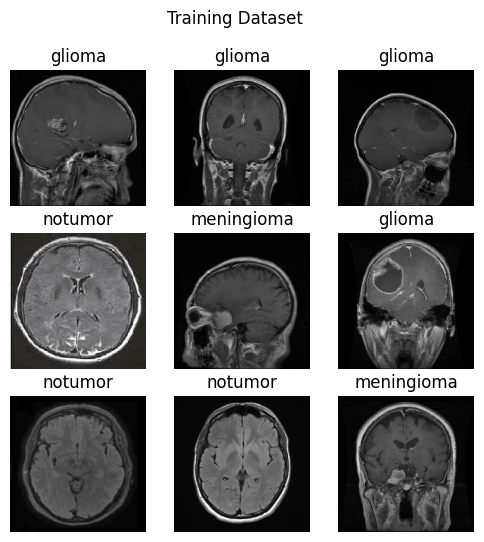

In [7]:
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            predicted_class_index = np.argmax(labels[i])
            plt.title(class_names[predicted_class_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_ds, "Training Dataset")

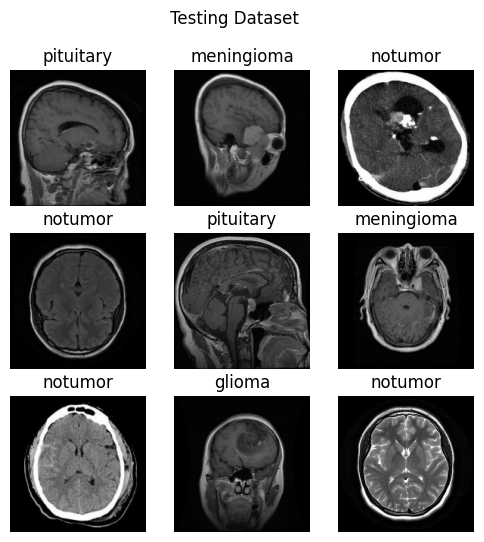

In [8]:
show_images(test_ds, 'Testing Dataset')

# Preprocess the Dataset

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
# Found 5712 images belonging to 4 classes.

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
# Found 1311 images belonging to 4 classes.

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Build the Model

In [10]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train the Model

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # changed to 'val_loss'
                               patience=3,
                               restore_best_weights=True)

history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=10,
                    steps_per_epoch=training_set.samples // training_set.batch_size,  # add this line
                    validation_steps=test_set.samples // test_set.batch_size,          # add this line
                    callbacks=[early_stopping])

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8311 - loss: 0.4604 - val_accuracy: 0.8336 - val_loss: 0.4562
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8125 - loss: 0.4072 - val_accuracy: 0.8387 - val_loss: 0.4294
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.8709 - loss: 0.3607 - val_accuracy: 0.8055 - val_loss: 0.5310
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8125 - loss: 0.3847 - val_accuracy: 0.8387 - val_loss: 0.5625
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.8847 - loss: 0.2963 - val_accuracy: 0.8687 - val_loss: 0.3277
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9062 - loss: 0.1376 - val_accuracy: 0.9032 - val_loss: 0.3788
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.9157 - loss: 0.2331 - val_accuracy: 0.8680 - val_loss: 0.3112
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8125 - loss: 0.3160 - val_accuracy

# Evaluate the Model

In [15]:
 loss, accuracy = model.evaluate(test_set)
 print(f'Test Accuracy: {accuracy:.2f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 644ms/step - accuracy: 0.8744 - loss: 0.2826
Test Accuracy: 0.87


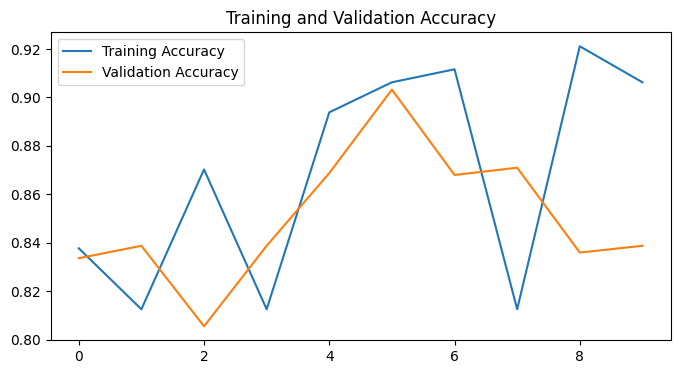

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

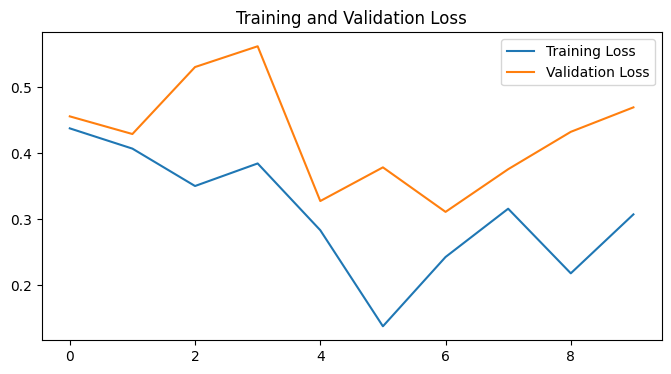

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the Model

In [18]:
model.save('brain_tumor_model.keras')  # Save in Keras format

# Predict on Custom Images

In [19]:
# Load the saved model
loaded_model = load_model('brain_tumor_model.keras')  # Changed to .keras

# Load and preprocess the custom image
img_path = '/content/Testing/glioma/Te-glTr_0000.jpg'
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Convert the image to array
img_array = image.img_to_array(img)

# Important: Add this line to expand dimensions for prediction
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (rescale pixel values)
img_array = img_array / 255.0  # Rescale to [0, 1]

# Now you can make predictions:
predictions = loaded_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


In [21]:
# Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Rescale pixel values (same as in training)
img_array = img_array / 255.0

# Make predictions
#predictions = loaded_model.predict(img_array)

# Decode the prediction (get the class with the highest probability)
predicted_class_index = np.argmax(predictions[0])  # Get the index of the class with the highest probability
predicted_class_label = class_names[predicted_class_index]  # Map index to label

print("Predicted class label:", predicted_class_label)

Predicted class label: glioma


In [22]:
# Class labels in the same order as used during training
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Output the predicted class
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class}')

Predicted class: glioma
